# ***Hourly Energy Consumption Prediction using XGBoost***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/PJME_hourly.csv'
pjme = pd.read_csv(file_path, index_col=[0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


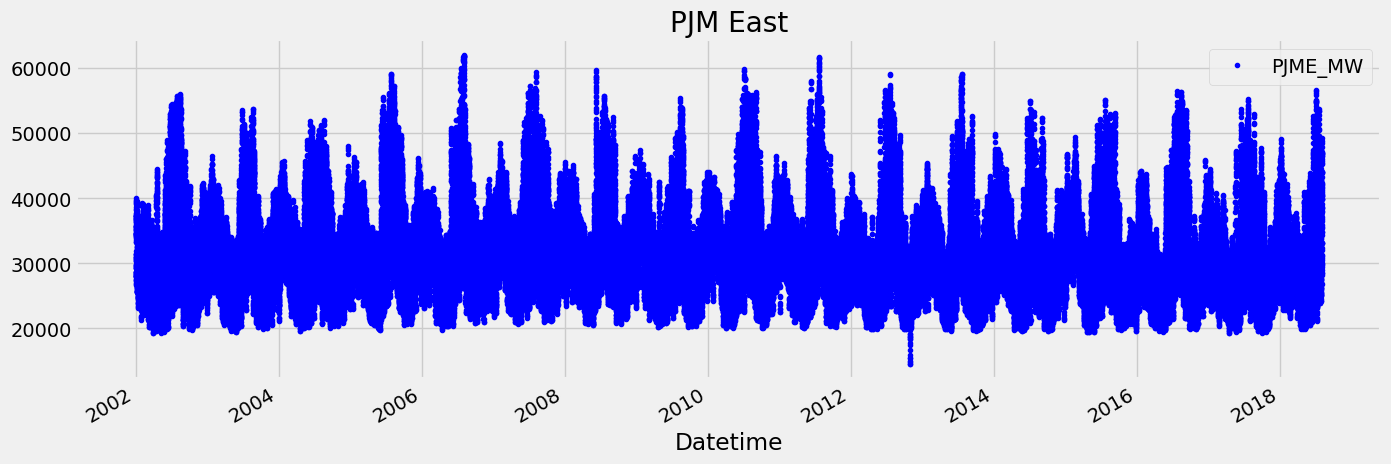

In [4]:
pjme.plot(style = '.' , color = "blue", figsize = (15,5), title = "PJM East");

**EDA**

In [5]:
pjme['date'] = pjme.index
pjme['hour'] = pjme['date'].dt.hour
pjme['dayofweek'] = pjme['date'].dt.dayofweek
pjme['quarter'] = pjme['date'].dt.quarter
pjme['month'] = pjme['date'].dt.month
pjme['year'] = pjme['date'].dt.year
pjme['dayofyear'] = pjme['date'].dt.dayofyear
pjme['dayofmonth'] = pjme['date'].dt.day
pjme['weekofyear'] = pjme['date'].dt.isocalendar().week
pjme.drop(['date'], axis=1, inplace=True)

In [6]:
pjme.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


In [7]:
pjme.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1,1,1
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2,2,1


In [8]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     145366 non-null  float64
 1   hour        145366 non-null  int32  
 2   dayofweek   145366 non-null  int32  
 3   quarter     145366 non-null  int32  
 4   month       145366 non-null  int32  
 5   year        145366 non-null  int32  
 6   dayofyear   145366 non-null  int32  
 7   dayofmonth  145366 non-null  int32  
 8   weekofyear  145366 non-null  UInt32 
dtypes: UInt32(1), float64(1), int32(7)
memory usage: 6.8 MB


In [9]:
pjme.isna().sum(axis = 0)

PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

<Axes: xlabel='hour', ylabel='PJME_MW'>

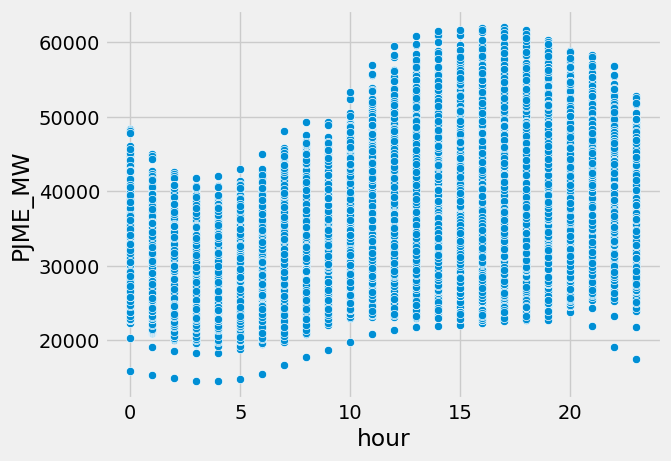

In [10]:
sns.scatterplot(x='hour', y='PJME_MW', data=pjme)


<Axes: xlabel='dayofweek', ylabel='PJME_MW'>

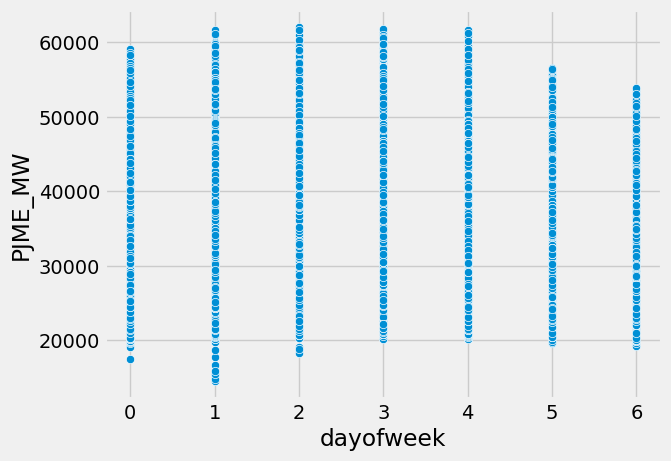

In [11]:
sns.scatterplot(x='dayofweek', y='PJME_MW', data=pjme)

<Axes: xlabel='month', ylabel='PJME_MW'>

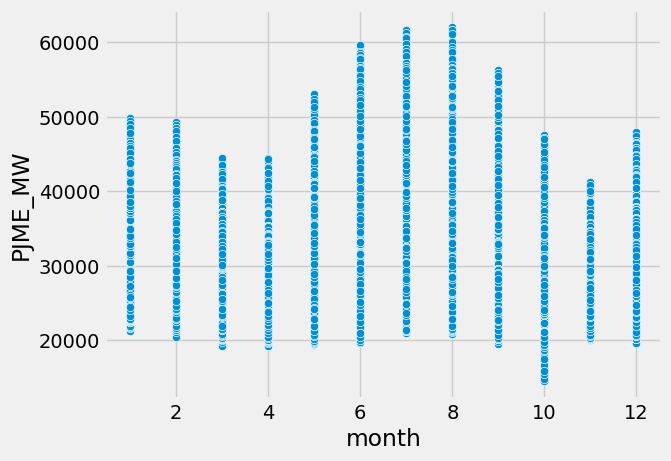

In [12]:
sns.scatterplot(x='month', y='PJME_MW', data=pjme)

<Axes: xlabel='year', ylabel='PJME_MW'>

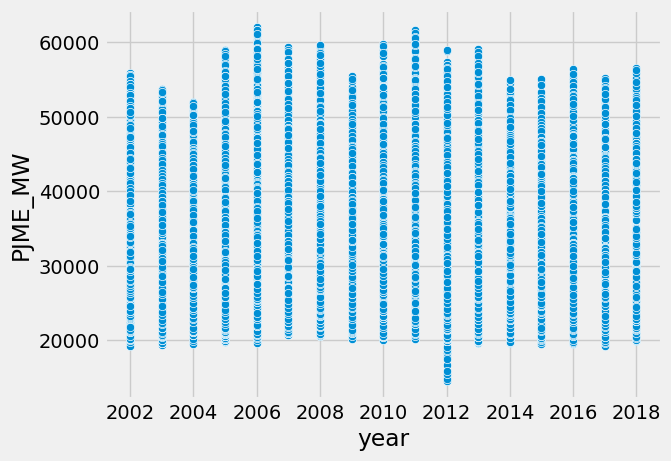

In [13]:
sns.scatterplot(x='year', y='PJME_MW', data=pjme)

<Axes: xlabel='weekofyear', ylabel='PJME_MW'>

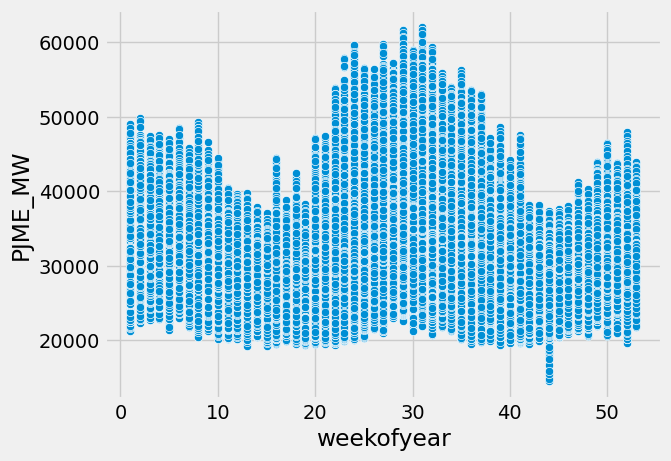

In [14]:
sns.scatterplot(x='weekofyear', y='PJME_MW', data=pjme)

**Train-Test Split**

Splitting the data after 2015 to use as test data set.

In [15]:
pjme_train = pjme.loc[pjme.year < 2015]
pjme_test = pjme.loc[pjme.year >= 2015]

In [16]:
pjme_train.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1,1,1
2014-01-01 23:00:00,32215.0,23,2,1,1,2014,1,1,1
2014-01-02 00:00:00,30159.0,0,3,1,1,2014,2,2,1


In [17]:
pjme_test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53


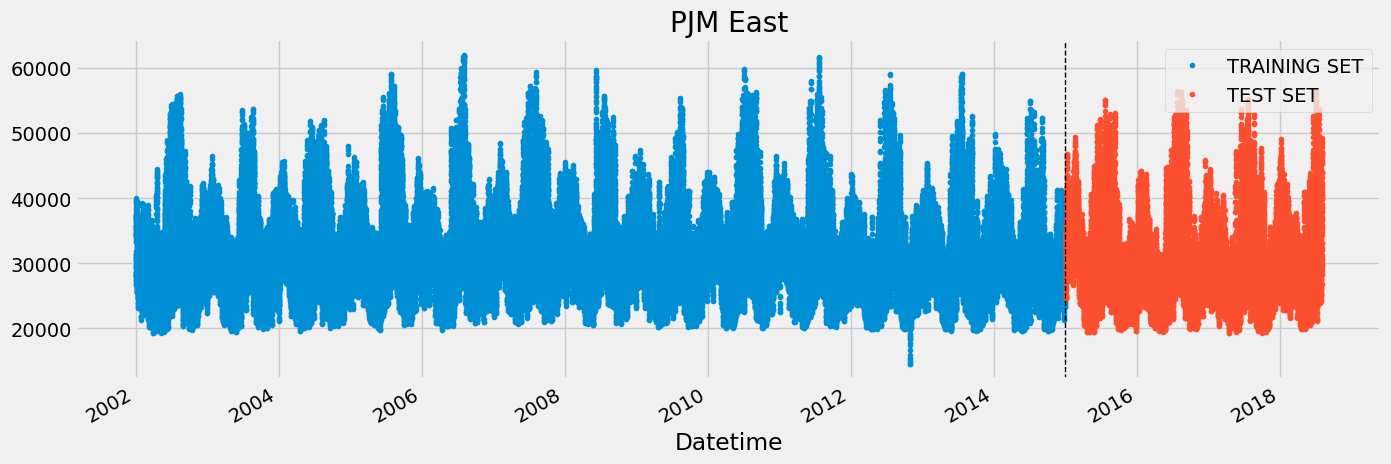

In [18]:
import matplotlib.pyplot as plt
import pandas as pd


pjme_train = pjme.loc[pjme.year < 2015]
pjme_test = pjme.loc[pjme.year >= 2015]


combined = pd.concat([
    pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
    pjme_test.rename(columns={'PJME_MW': 'TEST SET'})
], axis=0, sort=False)


ax = combined[['TRAINING SET', 'TEST SET']].plot(style='.', figsize=(15, 5), title="PJM East")


separator_date = pjme_test.index[0]
ax.axvline(x=separator_date, color='black', linestyle='--', linewidth=1)

plt.show()


In [19]:
x_train = pjme_train[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
x_test = pjme_test[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
y_train = pjme_train[['PJME_MW']]
y_test = pjme_test[['PJME_MW']]

**XG Boost Model**

In [20]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [32]:
import numpy as np
from xgboost import XGBRegressor


reg = XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bytree=1,
    gamma=0,
    importance_type='gain',
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=np.nan,
    n_estimators=1000,
    n_jobs=1,
    objective='reg:linear',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=True,
    subsample=1,
    early_stopping_rounds=50
)


reg.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=False
)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:05:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:05:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=1, num_parallel_tree=None, objective='reg:linear', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

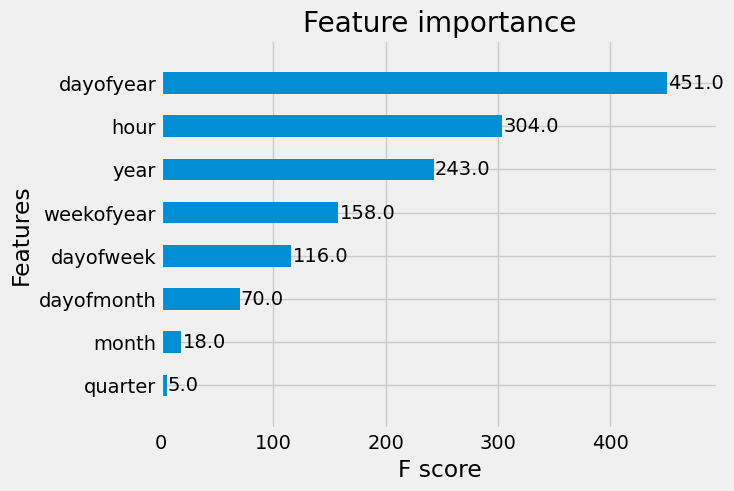

In [33]:
plot_importance(reg, height = 0.5)

In [34]:
pjme_test['MW_Prediction'] = reg.predict(x_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

<ipython-input-34-718a3d9e5890>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction'] = reg.predict(x_test)


<Axes: xlabel='Datetime'>

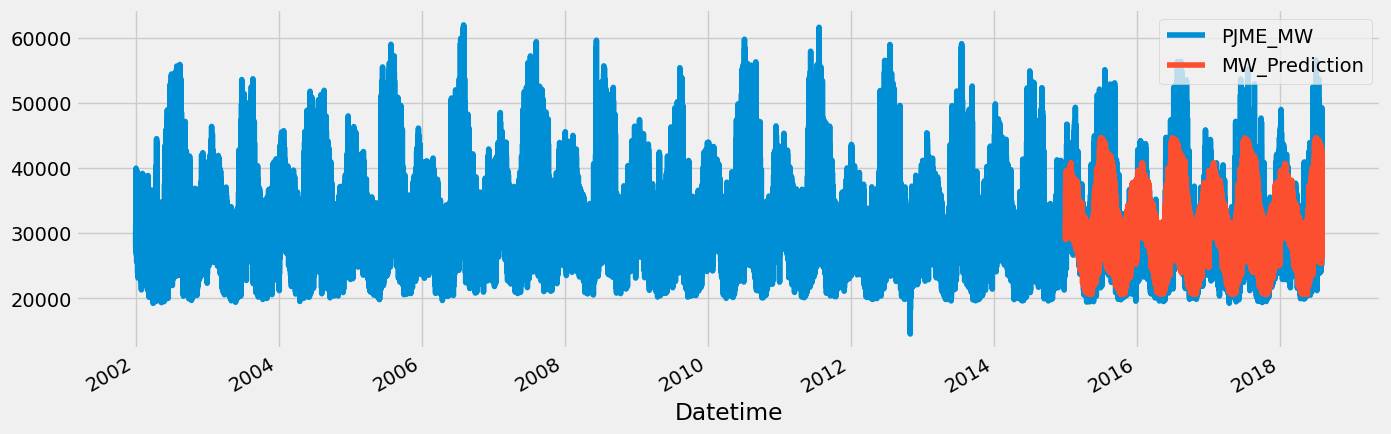

In [35]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

**First Month Prediction**

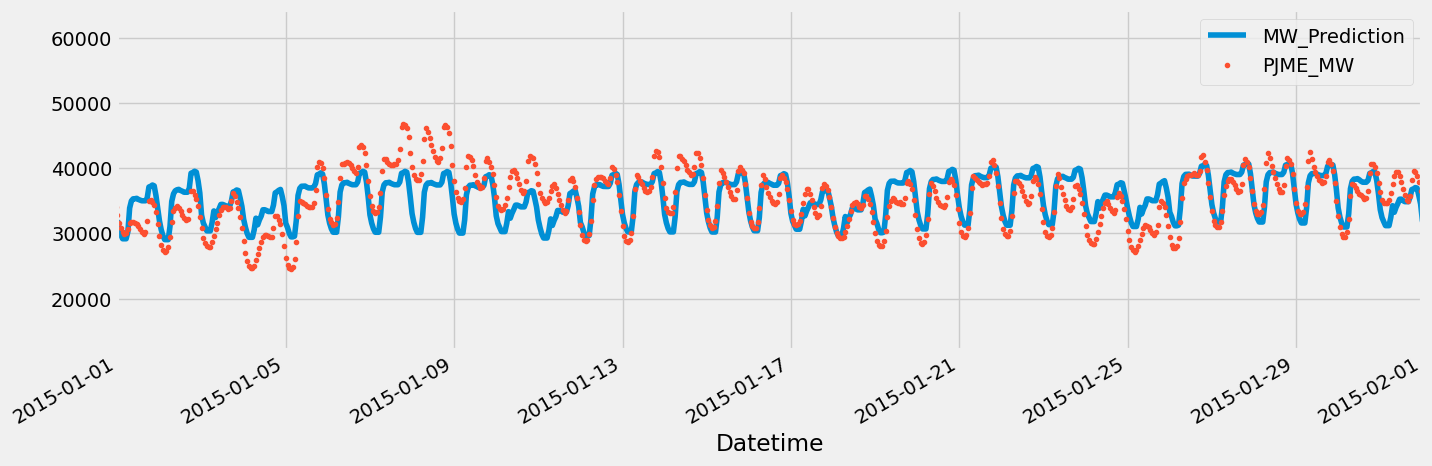

In [36]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

**First week of January Prediction**

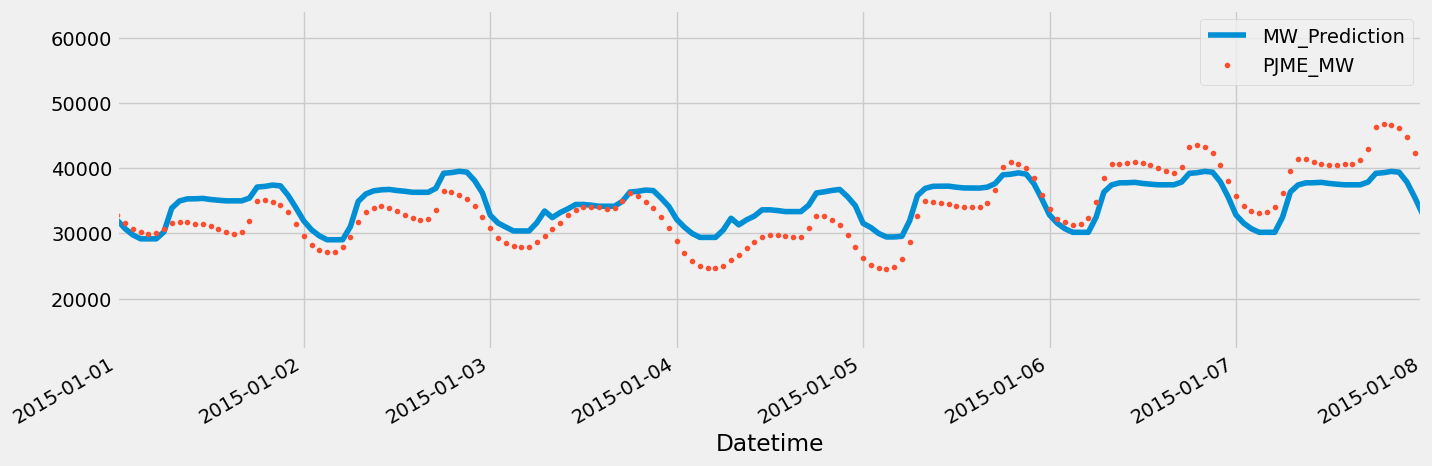

In [37]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')

**First Week of July Prediction**

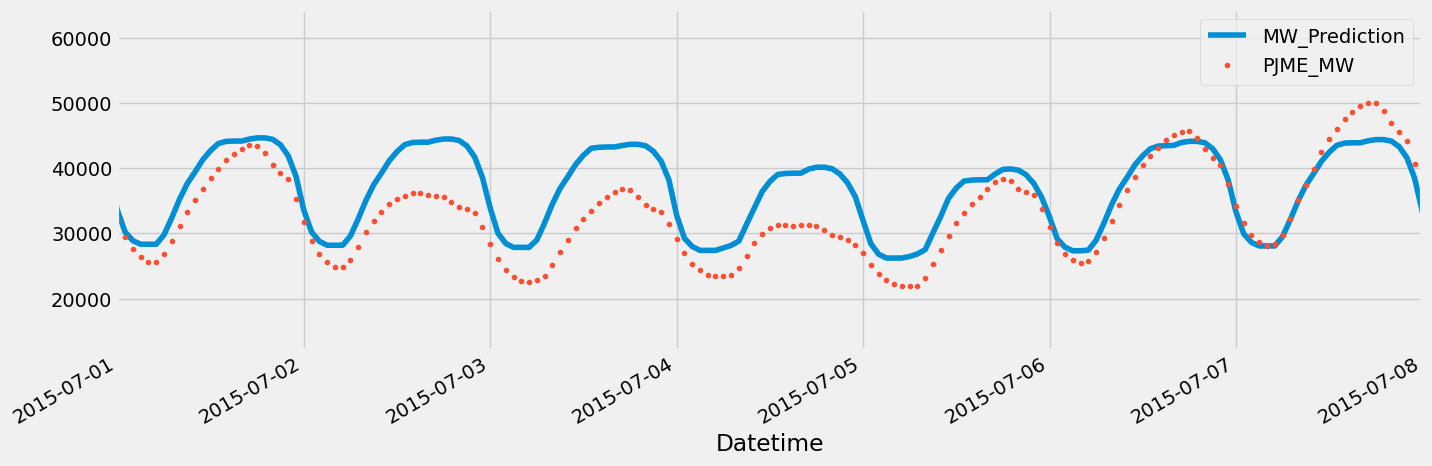

In [38]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')

**Evaluation Using Error Metrics**

In [39]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14025563.41850424

In [40]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2864.0078925135176

In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.989506655628599

**Analysis of worst and best predicted days**

In [44]:
pjme_test.loc[:, 'error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test.loc[:, 'abs_error'] = pjme_test['error'].apply(np.abs)

In [45]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [47]:
error_by_day.head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 1     1           31765.583333   33949.574219 -2183.991211  2666.977865
           2           32141.166667   35089.078125 -2947.910156  2947.910156
           3           32014.375000   33643.191406 -1628.818522  1636.179525
           4           28542.291667   32972.894531 -4430.604655  4430.604655
           5           33176.125000   35405.058594 -2228.935465  2811.037679
           6           38358.833333   35915.417969  2443.412923  2443.412923
           7           40181.875000   35915.417969  4266.454590  4266.454590
           8           42445.375000   35904.097656  6541.275065  6541.275065
           9           38524.666667   35589.808594  2934.856445  2941.300130
           10          37703.583333   33535.144531  4168.436686  4168.436686

**Over feorecasted days**

In [48]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37365.898438 -8965.939941  8965.939941
2017 2     24          26445.083333   34293.835938 -7848.753337  7848.753337
           25          24344.458333   31883.525391 -7539.068766  7539.068766
2015 7     3           30024.875000   37439.890625 -7415.015788  7415.015788
2017 5     29          24528.416667   31851.015625 -7322.598551  7322.598551
     2     20          27070.583333   34305.773438 -7235.189616  7235.189616
2018 1     28          27356.541667   34552.515625 -7195.974447  7195.974447
2017 1     26          30215.916667   37390.808594 -7174.890869  7174.890869
     6     28          30531.208333   37695.535156 -7164.328857  7164.328857
     2     8           28523.833333   35682.660156 -7158.826416  7158.826416

We notice that 1st worst day: 4th July,2016 - Independance Day Holiday 3rd worst day: 25th December,2015 - Christmas Holiday 5th worst day: 4th July,2016 - Independance Day Holiday

We need to consider holidays in our analysis for more accurate results.

**Worst Absolute Predicted days**

In [49]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31873.876953  13311.956868  13311.956868
           14          44427.333333   31135.677734  13291.654867  13291.654867
     9     10          40996.166667   29453.789062  11542.377035  11542.377035
           9           43836.958333   32353.906250  11483.052897  11483.052897
     8     12          45724.708333   34927.800781  10796.910075  10796.910075
2015 2     20          44694.041667   34047.996094  10646.048177  10646.048177
2018 1     6           43565.750000   33535.144531  10030.603353  10030.603353
2017 12    31          39016.000000   29097.138672   9918.860840   9918.860840
     5     19          38032.583333   28140.400391   9892.181234   9892.181234
2016 8     11          45225.458333   35473.847656   9751.610840   9751.610840

**Best Absolute Predicted days**

In [51]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27852.898438 -147.315755  263.895345
2015 10    28          28500.958333   28232.705078  268.252279  361.026367
2016 5     1           24503.625000   24573.578125  -69.953532  393.039307
     3     20          27989.416667   27721.945312  267.470866  415.581217
2015 11    1           24484.760000   24796.511719 -311.752344  471.507187
2016 9     16          29258.500000   29399.779297 -141.279378  496.053630
2017 5     2           28546.916667   28542.257812    4.657959  497.128499
2016 10    2           24659.083333   25150.906250 -491.821696  524.286051
2017 10    29          24605.666667   24825.892578 -220.227295  545.428955
2018 5     11          27865.333333   27958.556641  -93.224772  552.986003

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may.

**Plotting Best/Worst predicted Days**

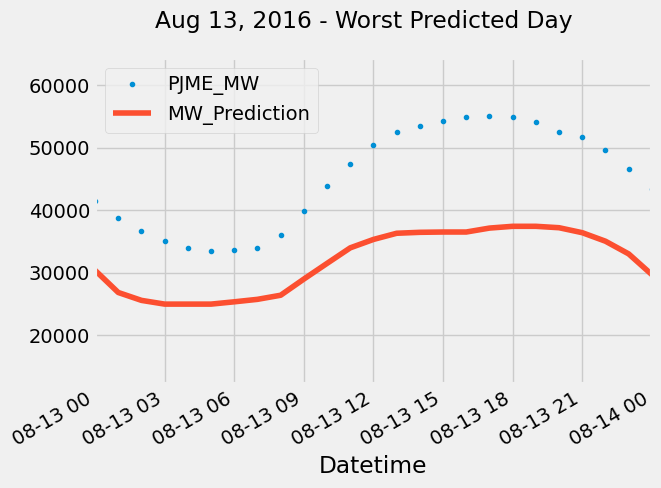

In [52]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

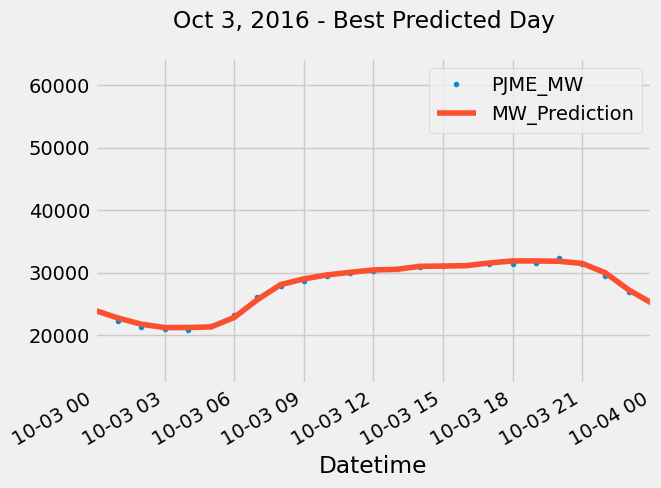

In [53]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

# From both the models we can discern that XGBoost method performed better in terms of the error metrics with MAPE of 8% compared to the MAPE for FB Prophet method which was 16%.

# It is also important to consider holidays in the prediction as it has an effect on the energy consumption rate.